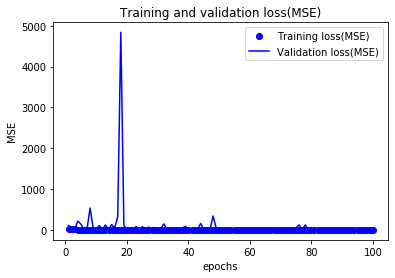

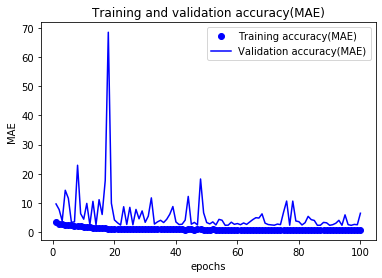

124/124 [==============================] - 1s 8ms/step - loss: 51.5185 - mean_absolute_error: 6.4653
Test MAE: 6.465
(3942, 1)
(3942,)
AxesSubplot(0.125,0.125;0.775x0.755)


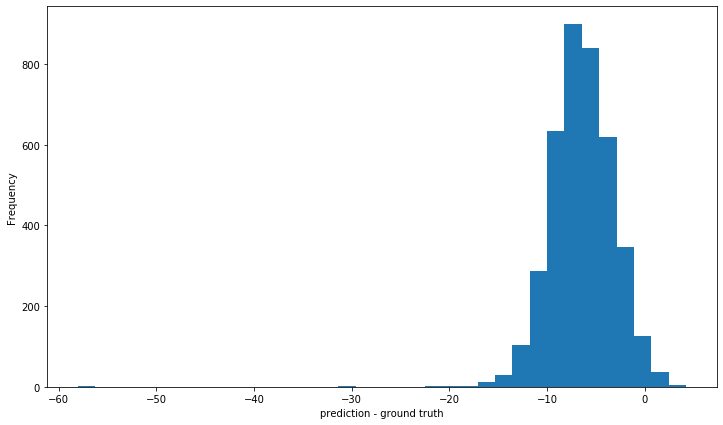

[[1.         0.58028508]
 [0.58028508 1.        ]]


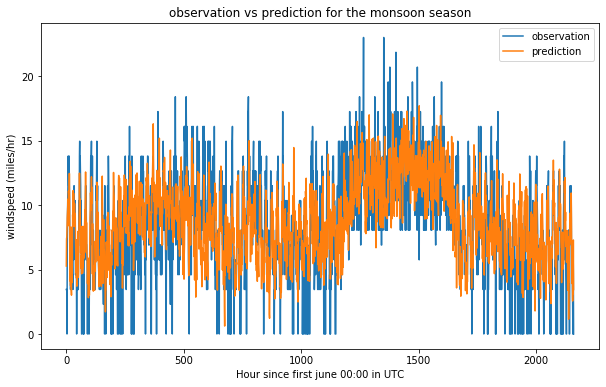

(8736, 1)
(8736,)
AxesSubplot(0.125,0.125;0.775x0.755)


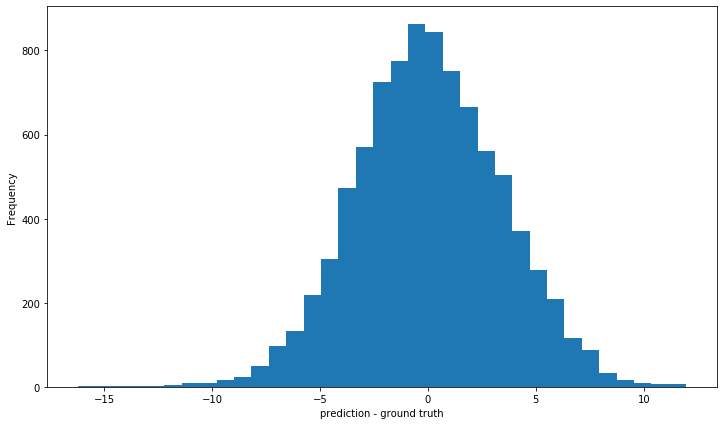

(7531,)
AxesSubplot(0.125,0.125;0.775x0.755)


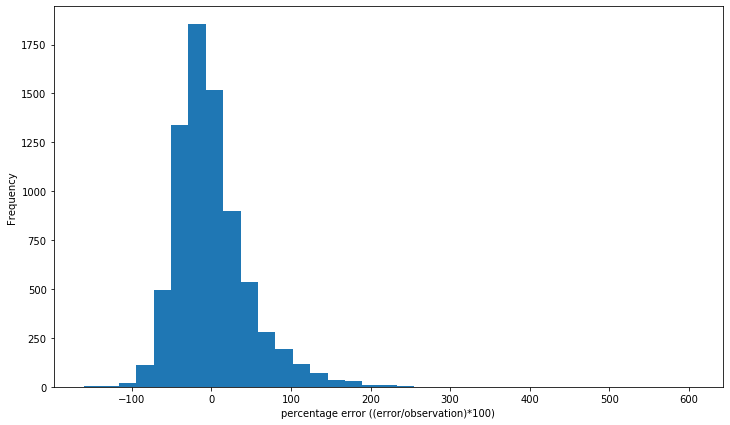

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


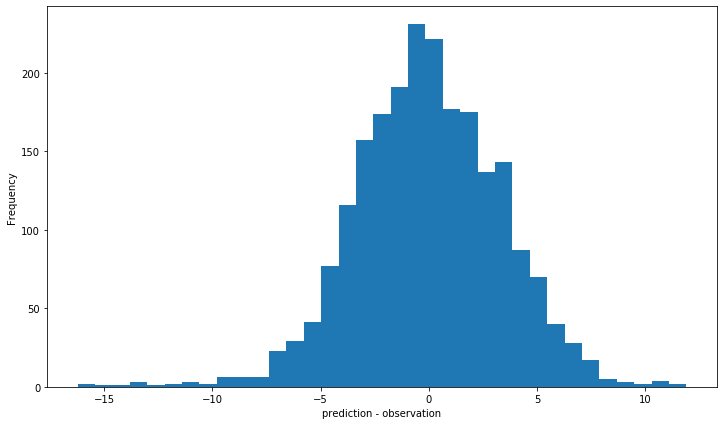

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


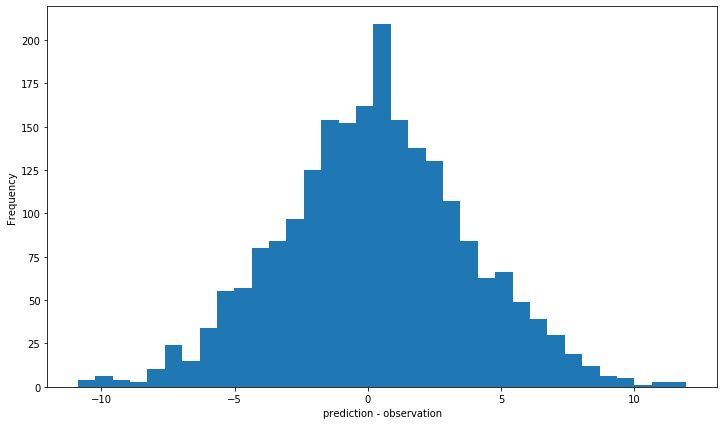

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


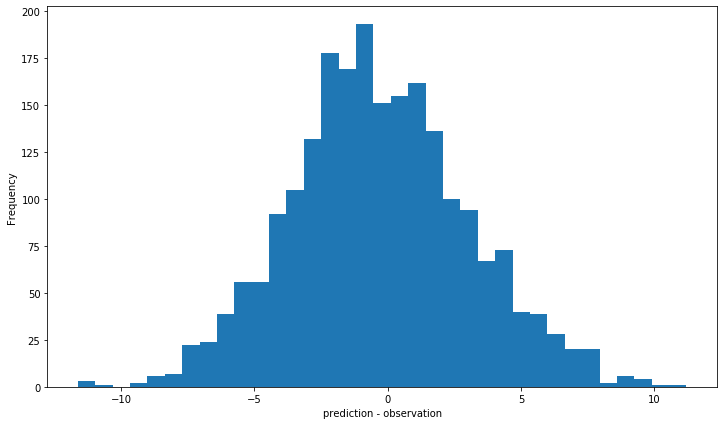

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


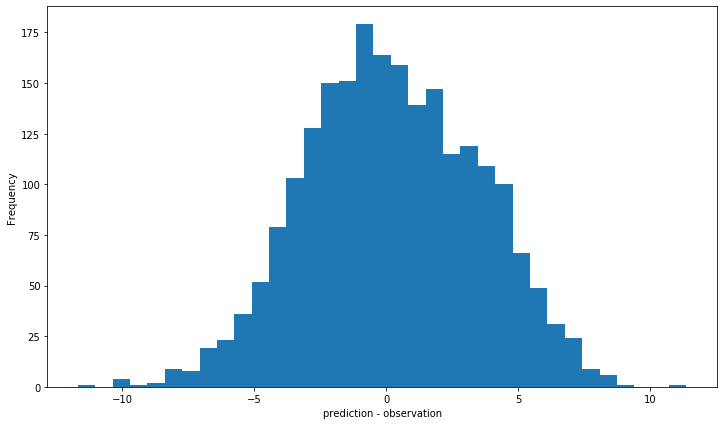

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_windspeed(code):
    arr = np.load("WindSpeed_ArrayFinal.npy")
    idx = airports.index(code)
    return arr[:, idx].astype(np.float32)

def get_era_full(param, level):
    arr = np.load("18To20{}{}_uint8.npy".format(param, level))
    return arr/256

# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

# data for a given airport
X = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
Y = get_windspeed('VABB').reshape(-1, 1)

import sklearn
from sklearn.model_selection import train_test_split

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, Y_train, Y_rem = train_test_split(X,Y, train_size=0.7)

# Now since we want the valid and test size to be equal. 
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem,Y_rem, test_size=0.5)

train_features = X_train
train_labels = Y_train
val_features = X_valid
val_labels = Y_valid
test_features = X_test
test_labels = Y_test

#to clear space for gpu, if occupied by any process
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

# model

initializer = tf.keras.initializers.HeUniform()
inputs = keras.Input(shape=(157, 157, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_initializer = initializer)(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
top_dropout_rate = 0.4
x = layers.Dropout(top_dropout_rate)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs, name="Basic2dCNN")

# compiling the model
opt =tf.keras.optimizers.RMSprop(learning_rate=0.002)
model.compile(loss = 'mse', optimizer = opt, metrics = [tf.keras.losses.MeanAbsoluteError()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath = f"wVABB_2D.keras",
                                            save_best_only = True, monitor = "val_loss")]

history = model.fit(train_features, train_labels, batch_size = 64, epochs = 100, validation_data = (val_features, val_labels), verbose = 0, callbacks = callbacks)

import matplotlib.pyplot as plt
%matplotlib inline
f1 = plt.figure();
mae = history.history["mean_absolute_error"]
loss = history.history["loss"]
val_mae = history.history["val_mean_absolute_error"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label = "Training loss(MSE)");
plt.plot(epochs, val_loss, "b", label = "Validation loss(MSE)");
plt.title("Training and validation loss(MSE)");
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend();

f2 = plt.figure();
plt.plot(epochs, mae, "bo", label = "Training accuracy(MAE)");
plt.plot(epochs, val_mae, "b", label = "Validation accuracy(MAE)");
plt.title("Training and validation accuracy(MAE)");
plt.legend();
plt.xlabel("epochs")
plt.ylabel("MAE")
plt.show();

test_loss, test_mae = model.evaluate(test_features, test_labels)
print(f"Test MAE: {test_mae:.3f}")
f1.savefig(f"wVABB_2D.jpg", bbox_inches='tight', dpi=600);
f2.savefig(f"wVABB_2D.jpg", bbox_inches='tight', dpi=600);

pred = model.predict(test_features)
error = pred - test_labels

import pandas as pd
print(error.shape)
error = np.reshape(error, (3942,))
print(error.shape)
x = pd.Series(error)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - ground truth")
plt.show();

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_windspeed(code):
    arr = np.load("windspeed21_22FINAL.npy")
    idx = airports.index(code)
    return arr[:, idx].astype(np.float32)

def get_era_full(param, level):
    arr = np.load("21To22{}{}_uint8final.npy".format(param, level))
    return arr/256

# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

# data for a given airport
X = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
Y = get_windspeed('VABB').reshape(-1, 1)

X_test = X
Y_test = Y

#to clear space for gpu, if occupied by any process
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

test_features = X_test
test_labels = Y_test

model = keras.models.load_model('wVABB_2D.keras', compile = False)
pred = model.predict(test_features)
error = pred - test_labels

remove_idx = []
for i, j in enumerate(list(test_labels)):
    if j == 0.0:
        remove_idx.append(i)
        
test_labels2 = np.reshape(test_labels, (8736,))
pred2 = np.reshape(pred, (8736,))
test_labels2 = np.delete(test_labels2, remove_idx)
pred2 = np.delete(pred2, remove_idx)
error0 = pred2 - test_labels2
percent_error = (error0/test_labels2)*100

pearson_matrix = np.corrcoef(test_labels2, pred2)
print(pearson_matrix)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
#plt.plot(range(24*90), test_labels[:24*90], label = "observation")
#plt.plot(range(24*90), pred[:24*90], label = "prediction")
plt.plot(range(24*90), test_labels[24*90:24*2*90], label = "observation")
plt.plot(range(24*90), pred[24*90:24*2*90], label = "prediction")
#plt.plot(range(24*90), test_labels[24*2*90:24*3*90], label = "observation")
#plt.plot(range(24*90), pred[24*2*90:24*3*90], label = "prediction")
#plt.plot(range(24*90), test_labels[24*3*90:24*4*90], label = "observation")
#plt.plot(range(24*90), pred[24*3*90:24*4*90], label = "prediction")
plt.title("observation vs prediction for the monsoon season")
plt.legend()
plt.xlabel("Hour since first june 00:00 in UTC")
plt.ylabel("windspeed (miles/hr)")
plt.show();

import pandas as pd
print(error.shape)
error = np.reshape(error, (8736,))
print(error.shape)
x = pd.Series(error)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - ground truth")
plt.show();

import pandas as pd
print(percent_error.shape)
#error = np.reshape(percent_error, (8736-1205,))
#print(error.shape)
y = pd.Series(percent_error)
print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("percentage error ((error/observation)*100)")
plt.show();

#plot for summer
import pandas as pd
summer_err = error[:2184]
monsoon_err = error[2184:2*2184]
autumn_err = error[2*2184:3*2184]
winter_err = error[3*2184:]
error1 = np.reshape(summer_err, (2184,))
print(error1.shape)
x = pd.Series(error1)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for monsoon
error2 = np.reshape(monsoon_err, (2184,))
print(error2.shape)
x = pd.Series(error2)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for autumn
error3 = np.reshape(autumn_err, (2184,))
print(error3.shape)
x = pd.Series(error3)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for winter
error4 = np.reshape(winter_err, (2184,))
print(error4.shape)
x = pd.Series(error4)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

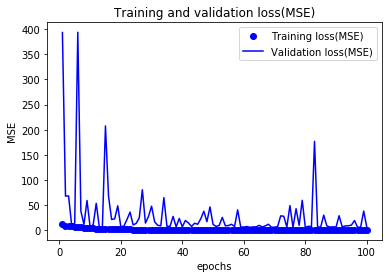

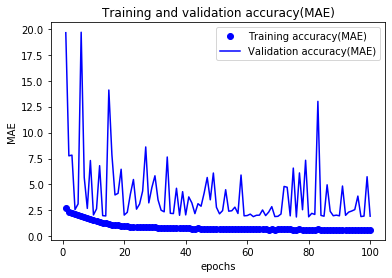

124/124 [==============================] - 2s 13ms/step - loss: 6.1108 - mean_absolute_error: 1.9350
Test MAE: 1.935
(3942, 1)
(3942,)
AxesSubplot(0.125,0.125;0.775x0.755)


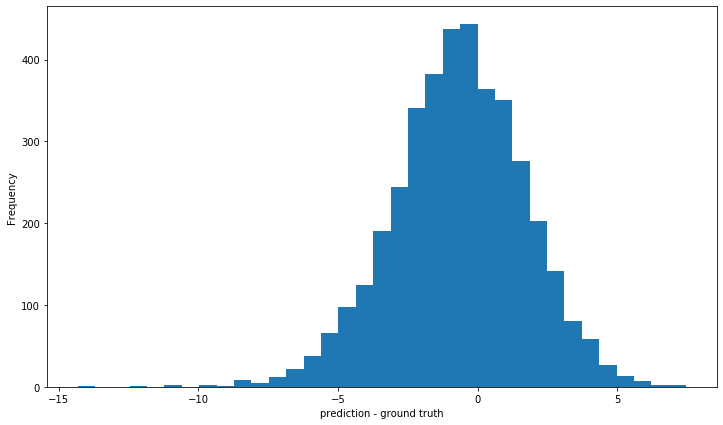

[[1.         0.50751333]
 [0.50751333 1.        ]]


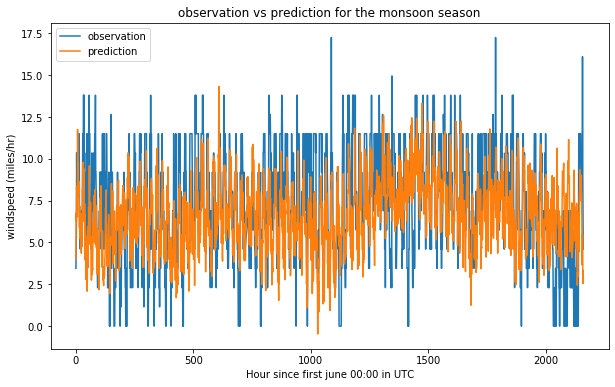

(8736, 1)
(8736,)
AxesSubplot(0.125,0.125;0.775x0.755)


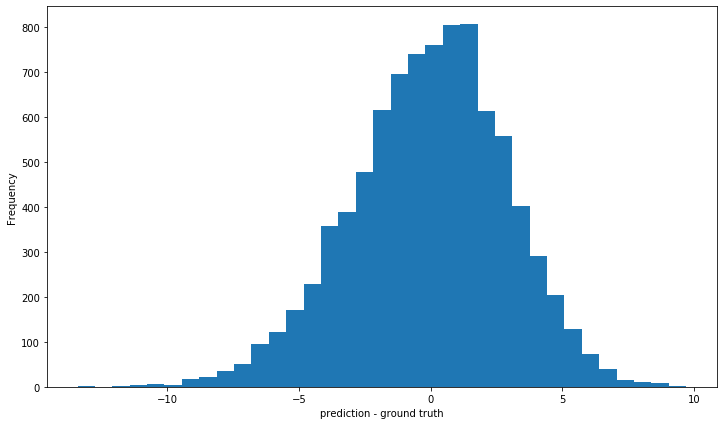

(7636,)
AxesSubplot(0.125,0.125;0.775x0.755)


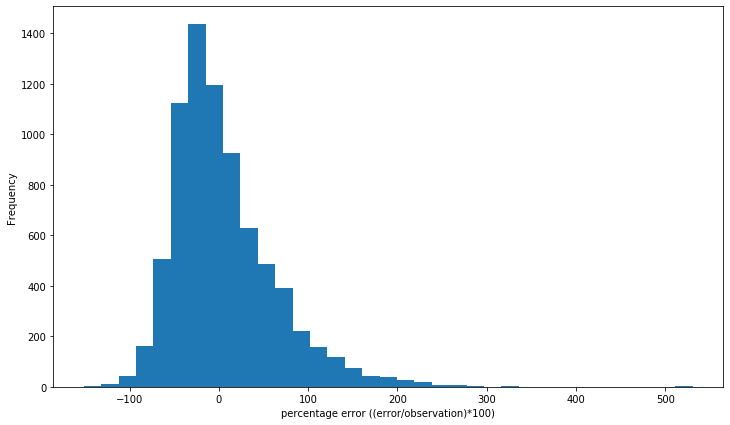

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


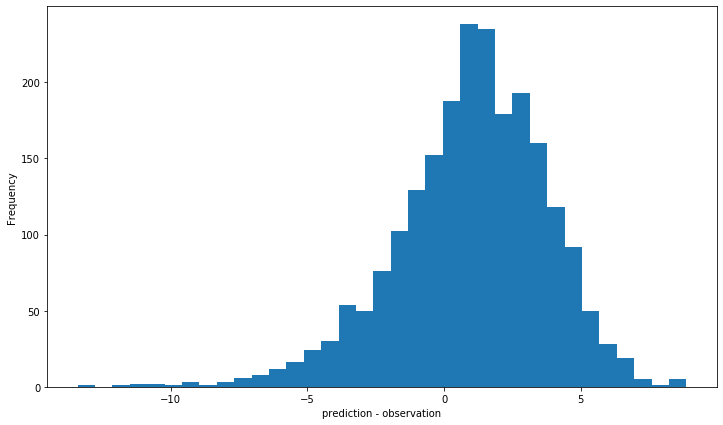

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


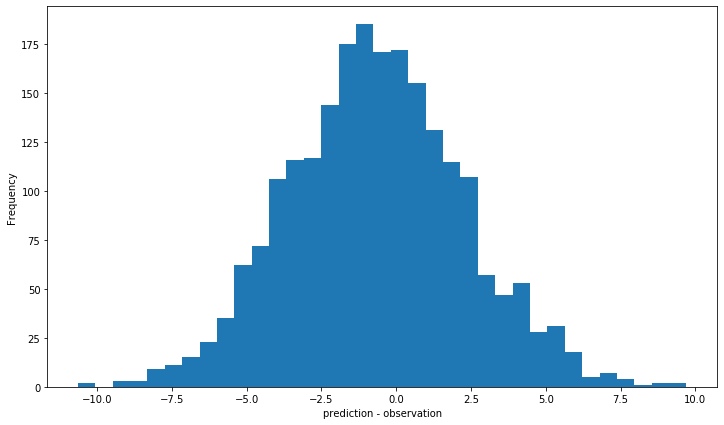

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


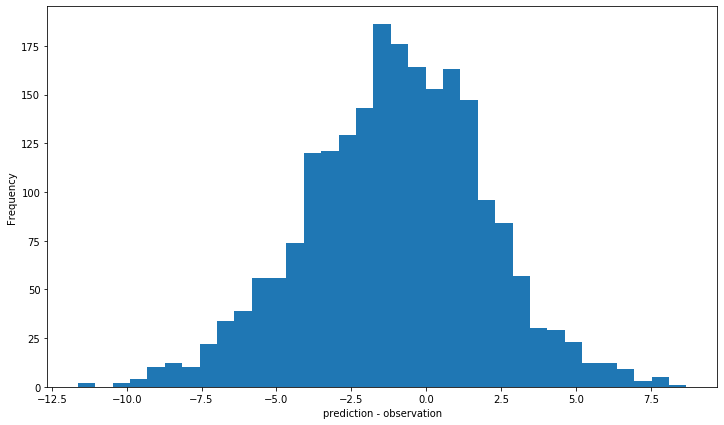

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


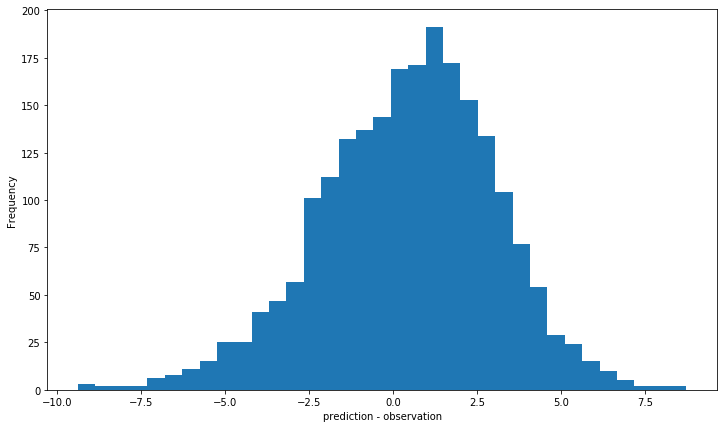

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_windspeed(code):
    arr = np.load("WindSpeed_ArrayFinal.npy")
    idx = airports.index(code)
    return arr[:, idx].astype(np.float32)

def get_era_full(param, level):
    arr = np.load("18To20{}{}_uint8.npy".format(param, level))
    return arr/256

# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

# data for a given airport
X = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
Y = get_windspeed('VOTV').reshape(-1, 1)

import sklearn
from sklearn.model_selection import train_test_split

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, Y_train, Y_rem = train_test_split(X,Y, train_size=0.7)

# Now since we want the valid and test size to be equal. 
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem,Y_rem, test_size=0.5)

train_features = X_train
train_labels = Y_train
val_features = X_valid
val_labels = Y_valid
test_features = X_test
test_labels = Y_test

#to clear space for gpu, if occupied by any process
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

# model

initializer = tf.keras.initializers.HeUniform()
inputs = keras.Input(shape=(157, 157, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_initializer = initializer)(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
top_dropout_rate = 0.4
x = layers.Dropout(top_dropout_rate)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs, name="Basic2dCNN")

# compiling the model
opt =tf.keras.optimizers.RMSprop(learning_rate=0.002)
model.compile(loss = 'mse', optimizer = opt, metrics = [tf.keras.losses.MeanAbsoluteError()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath = f"wVOTV_2D.keras",
                                            save_best_only = True, monitor = "val_loss")]

history = model.fit(train_features, train_labels, batch_size = 64, epochs = 100, validation_data = (val_features, val_labels), verbose = 0, callbacks = callbacks)

import matplotlib.pyplot as plt
%matplotlib inline
f1 = plt.figure();
mae = history.history["mean_absolute_error"]
loss = history.history["loss"]
val_mae = history.history["val_mean_absolute_error"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label = "Training loss(MSE)");
plt.plot(epochs, val_loss, "b", label = "Validation loss(MSE)");
plt.title("Training and validation loss(MSE)");
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend();

f2 = plt.figure();
plt.plot(epochs, mae, "bo", label = "Training accuracy(MAE)");
plt.plot(epochs, val_mae, "b", label = "Validation accuracy(MAE)");
plt.title("Training and validation accuracy(MAE)");
plt.legend();
plt.xlabel("epochs")
plt.ylabel("MAE")
plt.show();

test_loss, test_mae = model.evaluate(test_features, test_labels)
print(f"Test MAE: {test_mae:.3f}")
f1.savefig(f"wVOTV_2D.jpg", bbox_inches='tight', dpi=600);
f2.savefig(f"wVOTV_2D.jpg", bbox_inches='tight', dpi=600);

pred = model.predict(test_features)
error = pred - test_labels

import pandas as pd
print(error.shape)
error = np.reshape(error, (3942,))
print(error.shape)
x = pd.Series(error)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - ground truth")
plt.show();

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_windspeed(code):
    arr = np.load("windspeed21_22FINAL.npy")
    idx = airports.index(code)
    return arr[:, idx].astype(np.float32)

def get_era_full(param, level):
    arr = np.load("21To22{}{}_uint8final.npy".format(param, level))
    return arr/256

# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

# data for a given airport
X = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
Y = get_windspeed('VOTV').reshape(-1, 1)

X_test = X
Y_test = Y

#to clear space for gpu, if occupied by any process
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

test_features = X_test
test_labels = Y_test

model = keras.models.load_model('wVOTV_2D.keras', compile = False)
pred = model.predict(test_features)
error = pred - test_labels

remove_idx = []
for i, j in enumerate(list(test_labels)):
    if j == 0.0:
        remove_idx.append(i)
        
test_labels2 = np.reshape(test_labels, (8736,))
pred2 = np.reshape(pred, (8736,))
test_labels2 = np.delete(test_labels2, remove_idx)
pred2 = np.delete(pred2, remove_idx)
error0 = pred2 - test_labels2
percent_error = (error0/test_labels2)*100

pearson_matrix = np.corrcoef(test_labels2, pred2)
print(pearson_matrix)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
#plt.plot(range(24*90), test_labels[:24*90], label = "observation")
#plt.plot(range(24*90), pred[:24*90], label = "prediction")
plt.plot(range(24*90), test_labels[24*90:24*2*90], label = "observation")
plt.plot(range(24*90), pred[24*90:24*2*90], label = "prediction")
#plt.plot(range(24*90), test_labels[24*2*90:24*3*90], label = "observation")
#plt.plot(range(24*90), pred[24*2*90:24*3*90], label = "prediction")
#plt.plot(range(24*90), test_labels[24*3*90:24*4*90], label = "observation")
#plt.plot(range(24*90), pred[24*3*90:24*4*90], label = "prediction")
plt.title("observation vs prediction for the monsoon season")
plt.legend()
plt.xlabel("Hour since first june 00:00 in UTC")
plt.ylabel("windspeed (miles/hr)")
plt.show();

import pandas as pd
print(error.shape)
error = np.reshape(error, (8736,))
print(error.shape)
x = pd.Series(error)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - ground truth")
plt.show();

import pandas as pd
print(percent_error.shape)
#error = np.reshape(percent_error, (8736-1205,))
#print(error.shape)
y = pd.Series(percent_error)
print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("percentage error ((error/observation)*100)")
plt.show();

#plot for summer
import pandas as pd
summer_err = error[:2184]
monsoon_err = error[2184:2*2184]
autumn_err = error[2*2184:3*2184]
winter_err = error[3*2184:]
error1 = np.reshape(summer_err, (2184,))
print(error1.shape)
x = pd.Series(error1)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for monsoon
error2 = np.reshape(monsoon_err, (2184,))
print(error2.shape)
x = pd.Series(error2)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for autumn
error3 = np.reshape(autumn_err, (2184,))
print(error3.shape)
x = pd.Series(error3)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for winter
error4 = np.reshape(winter_err, (2184,))
print(error4.shape)
x = pd.Series(error4)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

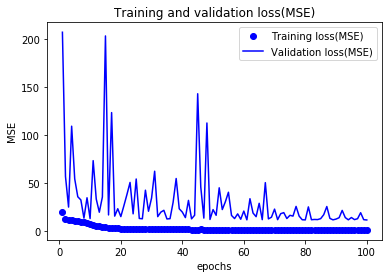

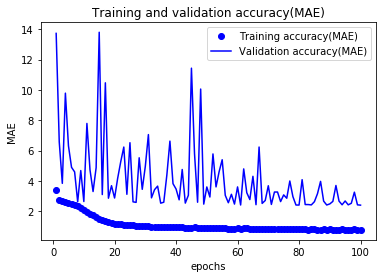

124/124 [==============================] - 1s 12ms/step - loss: 8.8137 - mean_absolute_error: 2.3401
Test MAE: 2.340
(3942, 1)
(3942,)
AxesSubplot(0.125,0.125;0.775x0.755)


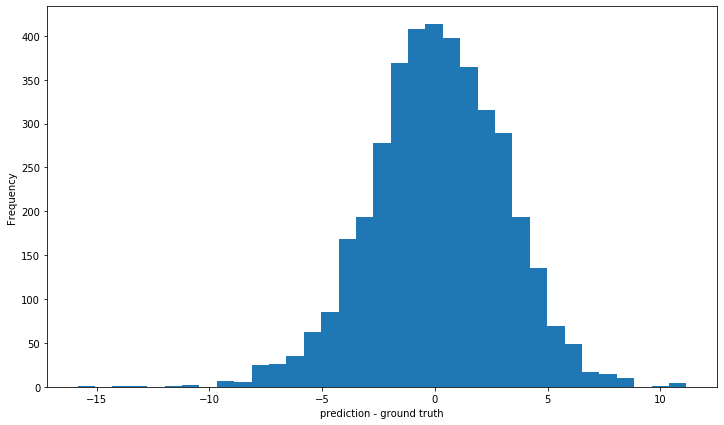

[[1.         0.64836289]
 [0.64836289 1.        ]]


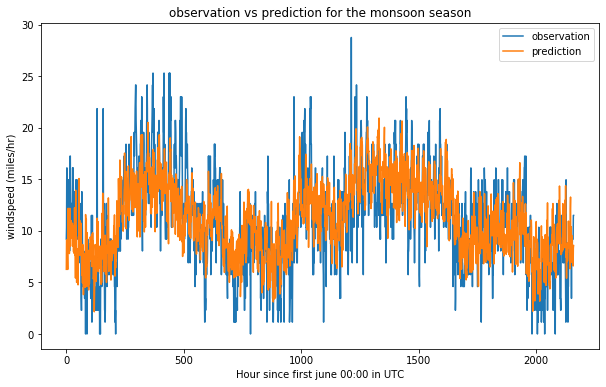

(8736, 1)
(8736,)
AxesSubplot(0.125,0.125;0.775x0.755)


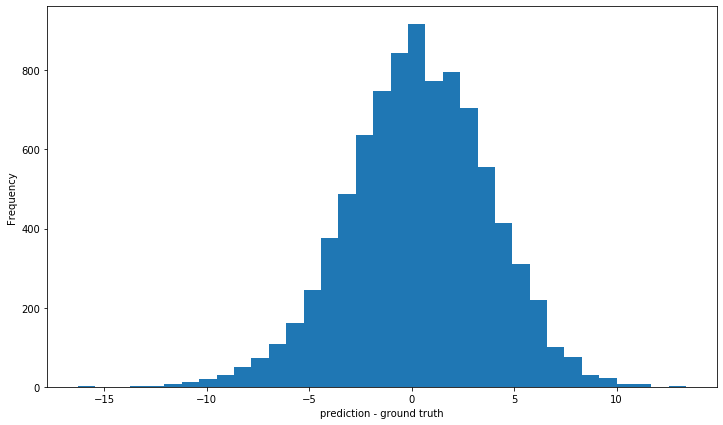

(8536,)
AxesSubplot(0.125,0.125;0.775x0.755)


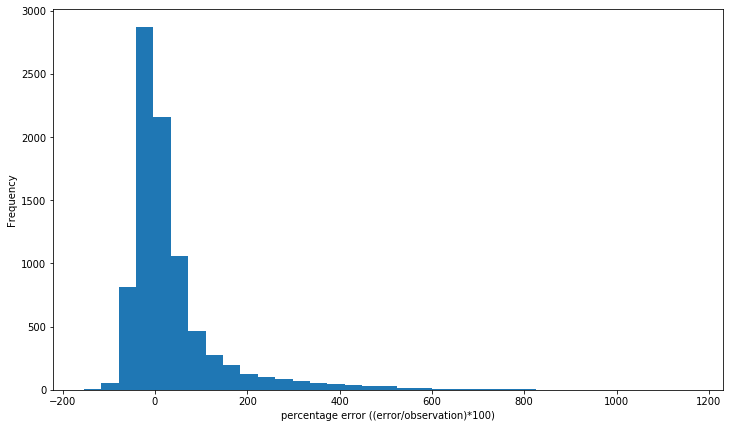

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


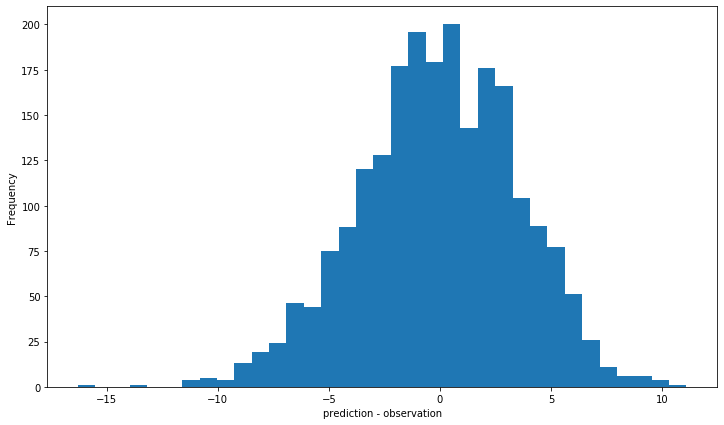

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


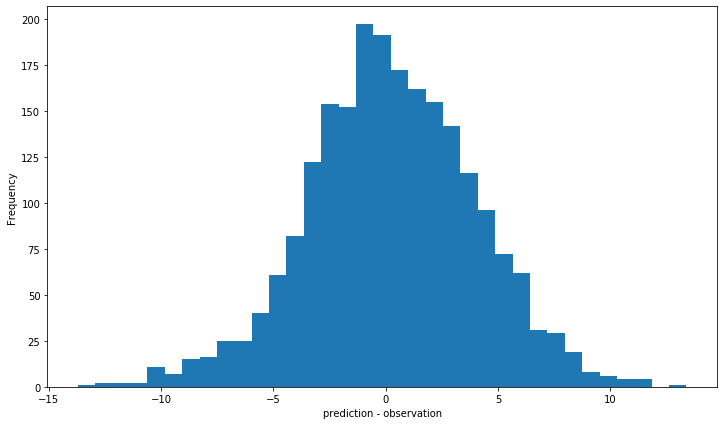

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


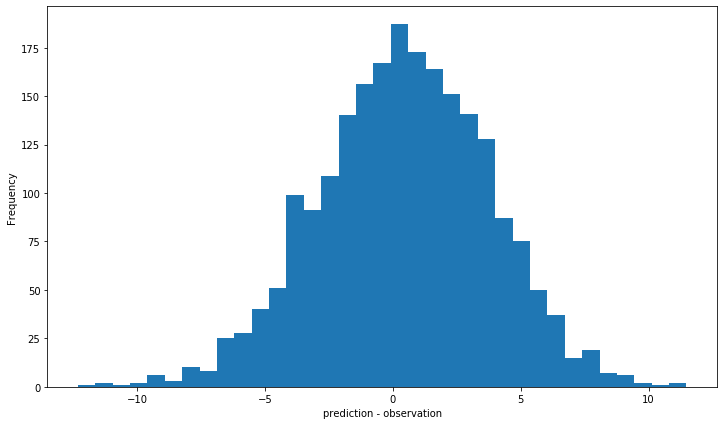

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


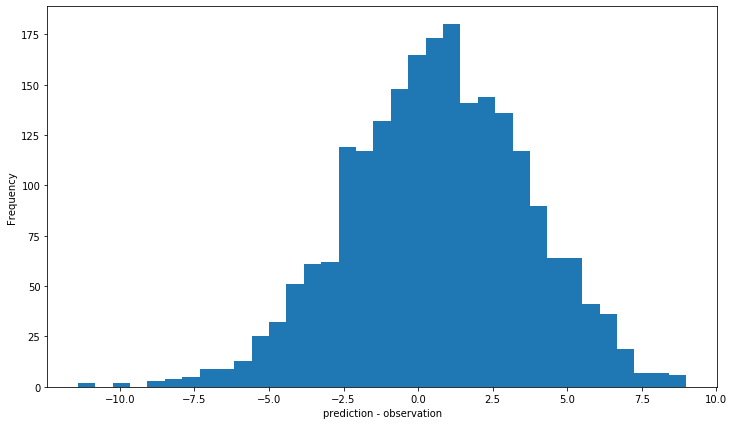

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_windspeed(code):
    arr = np.load("WindSpeed_ArrayFinal.npy")
    idx = airports.index(code)
    return arr[:, idx].astype(np.float32)

def get_era_full(param, level):
    arr = np.load("18To20{}{}_uint8.npy".format(param, level))
    return arr/256

# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

# data for a given airport
X = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
Y = get_windspeed('VOBL').reshape(-1, 1)

import sklearn
from sklearn.model_selection import train_test_split

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, Y_train, Y_rem = train_test_split(X,Y, train_size=0.7)

# Now since we want the valid and test size to be equal. 
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem,Y_rem, test_size=0.5)

train_features = X_train
train_labels = Y_train
val_features = X_valid
val_labels = Y_valid
test_features = X_test
test_labels = Y_test

#to clear space for gpu, if occupied by any process
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

# model

initializer = tf.keras.initializers.HeUniform()
inputs = keras.Input(shape=(157, 157, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_initializer = initializer)(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
top_dropout_rate = 0.4
x = layers.Dropout(top_dropout_rate)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs, name="Basic2dCNN")

# compiling the model
opt =tf.keras.optimizers.RMSprop(learning_rate=0.002)
model.compile(loss = 'mse', optimizer = opt, metrics = [tf.keras.losses.MeanAbsoluteError()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath = f"wVOBL_2D.keras",
                                            save_best_only = True, monitor = "val_loss")]

history = model.fit(train_features, train_labels, batch_size = 64, epochs = 100, validation_data = (val_features, val_labels), verbose = 0, callbacks = callbacks)

import matplotlib.pyplot as plt
%matplotlib inline
f1 = plt.figure();
mae = history.history["mean_absolute_error"]
loss = history.history["loss"]
val_mae = history.history["val_mean_absolute_error"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label = "Training loss(MSE)");
plt.plot(epochs, val_loss, "b", label = "Validation loss(MSE)");
plt.title("Training and validation loss(MSE)");
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend();

f2 = plt.figure();
plt.plot(epochs, mae, "bo", label = "Training accuracy(MAE)");
plt.plot(epochs, val_mae, "b", label = "Validation accuracy(MAE)");
plt.title("Training and validation accuracy(MAE)");
plt.legend();
plt.xlabel("epochs")
plt.ylabel("MAE")
plt.show();

test_loss, test_mae = model.evaluate(test_features, test_labels)
print(f"Test MAE: {test_mae:.3f}")
f1.savefig(f"wVOBL_2D.jpg", bbox_inches='tight', dpi=600);
f2.savefig(f"wVOBL_2D.jpg", bbox_inches='tight', dpi=600);

pred = model.predict(test_features)
error = pred - test_labels

import pandas as pd
print(error.shape)
error = np.reshape(error, (3942,))
print(error.shape)
x = pd.Series(error)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - ground truth")
plt.show();

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_windspeed(code):
    arr = np.load("windspeed21_22FINAL.npy")
    idx = airports.index(code)
    return arr[:, idx].astype(np.float32)

def get_era_full(param, level):
    arr = np.load("21To22{}{}_uint8final.npy".format(param, level))
    return arr/256

# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

# data for a given airport
X = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
Y = get_windspeed('VOBL').reshape(-1, 1)

X_test = X
Y_test = Y

#to clear space for gpu, if occupied by any process
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

test_features = X_test
test_labels = Y_test

model = keras.models.load_model('wVOBL_2D.keras', compile = False)
pred = model.predict(test_features)
error = pred - test_labels

remove_idx = []
for i, j in enumerate(list(test_labels)):
    if j == 0.0:
        remove_idx.append(i)
        
test_labels2 = np.reshape(test_labels, (8736,))
pred2 = np.reshape(pred, (8736,))
test_labels2 = np.delete(test_labels2, remove_idx)
pred2 = np.delete(pred2, remove_idx)
error0 = pred2 - test_labels2
percent_error = (error0/test_labels2)*100

pearson_matrix = np.corrcoef(test_labels2, pred2)
print(pearson_matrix)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
#plt.plot(range(24*90), test_labels[:24*90], label = "observation")
#plt.plot(range(24*90), pred[:24*90], label = "prediction")
plt.plot(range(24*90), test_labels[24*90:24*2*90], label = "observation")
plt.plot(range(24*90), pred[24*90:24*2*90], label = "prediction")
#plt.plot(range(24*90), test_labels[24*2*90:24*3*90], label = "observation")
#plt.plot(range(24*90), pred[24*2*90:24*3*90], label = "prediction")
#plt.plot(range(24*90), test_labels[24*3*90:24*4*90], label = "observation")
#plt.plot(range(24*90), pred[24*3*90:24*4*90], label = "prediction")
plt.title("observation vs prediction for the monsoon season")
plt.legend()
plt.xlabel("Hour since first june 00:00 in UTC")
plt.ylabel("windspeed (miles/hr)")
plt.show();

import pandas as pd
print(error.shape)
error = np.reshape(error, (8736,))
print(error.shape)
x = pd.Series(error)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - ground truth")
plt.show();

import pandas as pd
print(percent_error.shape)
#error = np.reshape(percent_error, (8736-1205,))
#print(error.shape)
y = pd.Series(percent_error)
print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("percentage error ((error/observation)*100)")
plt.show();

#plot for summer
import pandas as pd
summer_err = error[:2184]
monsoon_err = error[2184:2*2184]
autumn_err = error[2*2184:3*2184]
winter_err = error[3*2184:]
error1 = np.reshape(summer_err, (2184,))
print(error1.shape)
x = pd.Series(error1)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for monsoon
error2 = np.reshape(monsoon_err, (2184,))
print(error2.shape)
x = pd.Series(error2)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for autumn
error3 = np.reshape(autumn_err, (2184,))
print(error3.shape)
x = pd.Series(error3)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for winter
error4 = np.reshape(winter_err, (2184,))
print(error4.shape)
x = pd.Series(error4)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

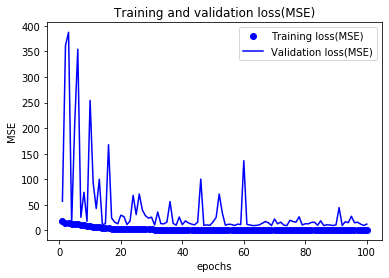

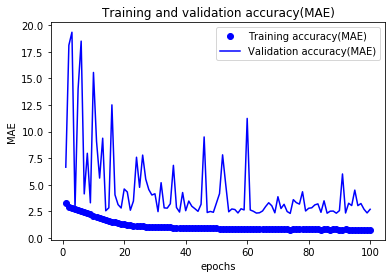

124/124 [==============================] - 2s 12ms/step - loss: 17.1060 - mean_absolute_error: 2.7859
Test MAE: 2.786
(3942, 1)
(3942,)
AxesSubplot(0.125,0.125;0.775x0.755)


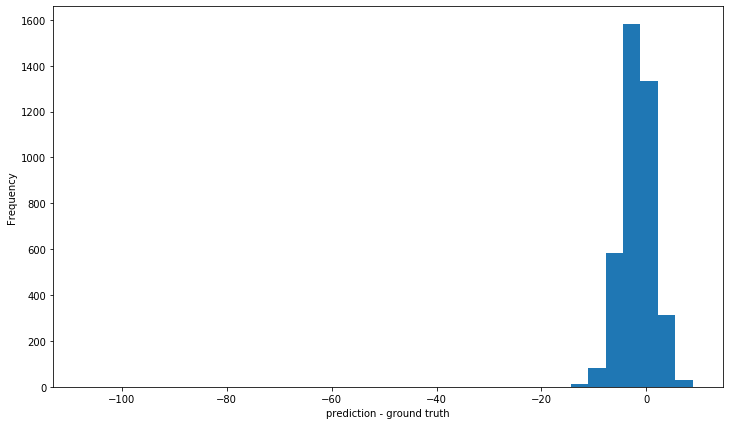

[[1.         0.40316432]
 [0.40316432 1.        ]]


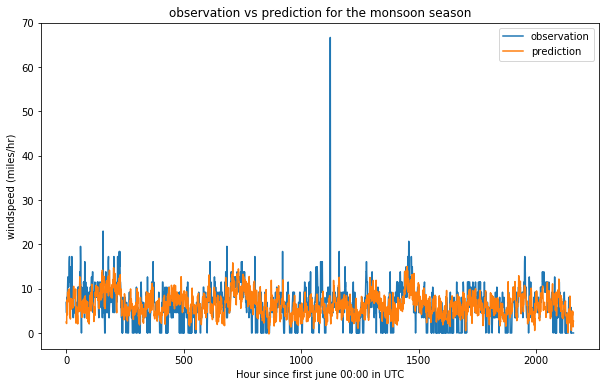

(8736, 1)
(8736,)
AxesSubplot(0.125,0.125;0.775x0.755)


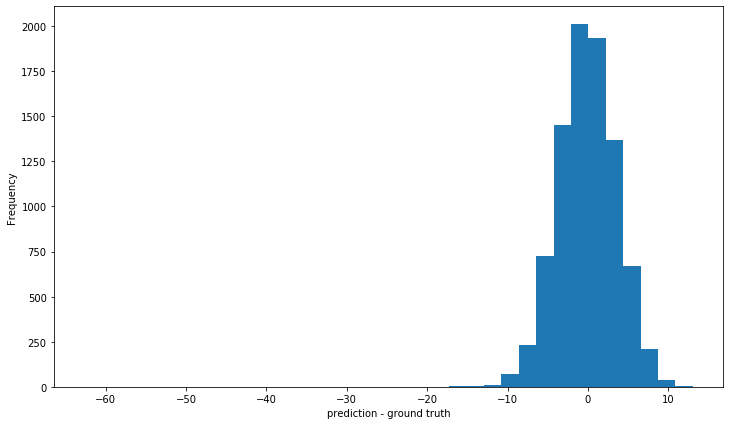

(6539,)
AxesSubplot(0.125,0.125;0.775x0.755)


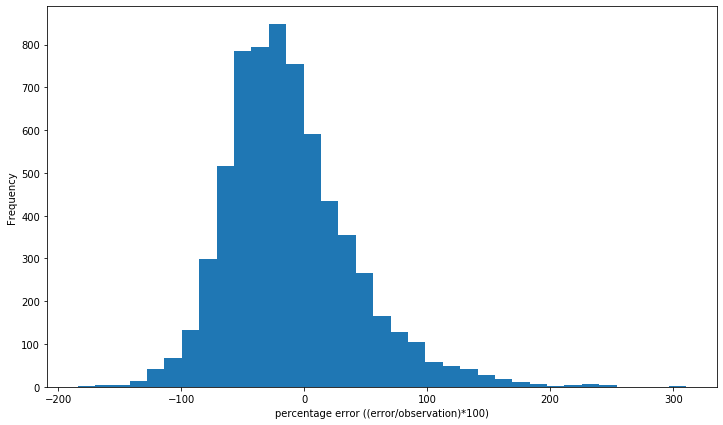

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


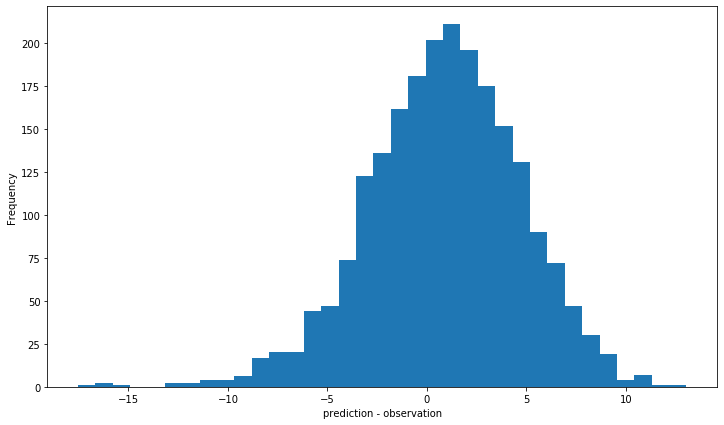

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


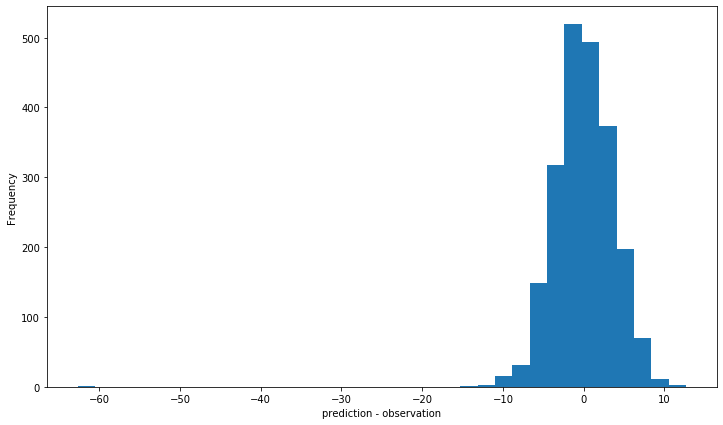

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


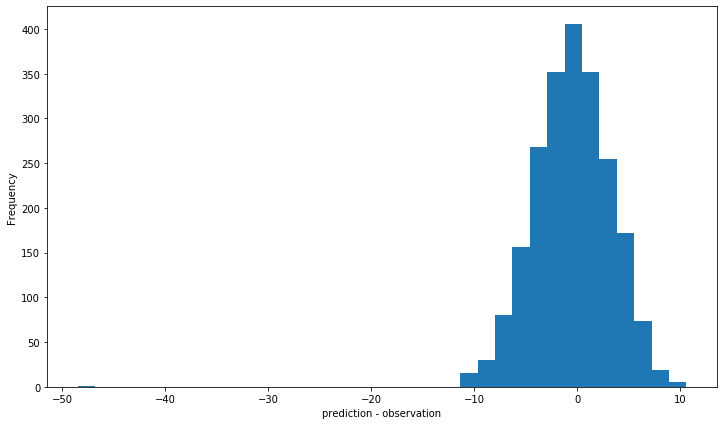

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


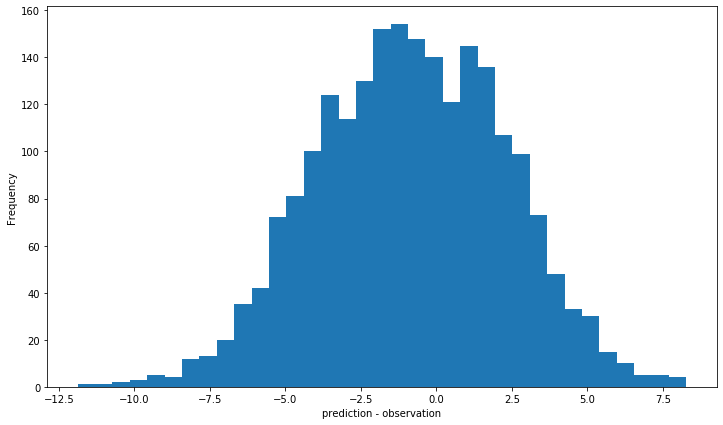

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_windspeed(code):
    arr = np.load("WindSpeed_ArrayFinal.npy")
    idx = airports.index(code)
    return arr[:, idx].astype(np.float32)

def get_era_full(param, level):
    arr = np.load("18To20{}{}_uint8.npy".format(param, level))
    return arr/256

# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

# data for a given airport
X = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
Y = get_windspeed('VECC').reshape(-1, 1)

import sklearn
from sklearn.model_selection import train_test_split

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, Y_train, Y_rem = train_test_split(X,Y, train_size=0.7)

# Now since we want the valid and test size to be equal. 
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem,Y_rem, test_size=0.5)

train_features = X_train
train_labels = Y_train
val_features = X_valid
val_labels = Y_valid
test_features = X_test
test_labels = Y_test

#to clear space for gpu, if occupied by any process
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

# model

initializer = tf.keras.initializers.HeUniform()
inputs = keras.Input(shape=(157, 157, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_initializer = initializer)(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
top_dropout_rate = 0.4
x = layers.Dropout(top_dropout_rate)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs, name="Basic2dCNN")

# compiling the model
opt =tf.keras.optimizers.RMSprop(learning_rate=0.002)
model.compile(loss = 'mse', optimizer = opt, metrics = [tf.keras.losses.MeanAbsoluteError()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath = f"wVECC_2D.keras",
                                            save_best_only = True, monitor = "val_loss")]

history = model.fit(train_features, train_labels, batch_size = 64, epochs = 100, validation_data = (val_features, val_labels), verbose = 0, callbacks = callbacks)

import matplotlib.pyplot as plt
%matplotlib inline
f1 = plt.figure();
mae = history.history["mean_absolute_error"]
loss = history.history["loss"]
val_mae = history.history["val_mean_absolute_error"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label = "Training loss(MSE)");
plt.plot(epochs, val_loss, "b", label = "Validation loss(MSE)");
plt.title("Training and validation loss(MSE)");
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend();

f2 = plt.figure();
plt.plot(epochs, mae, "bo", label = "Training accuracy(MAE)");
plt.plot(epochs, val_mae, "b", label = "Validation accuracy(MAE)");
plt.title("Training and validation accuracy(MAE)");
plt.legend();
plt.xlabel("epochs")
plt.ylabel("MAE")
plt.show();

test_loss, test_mae = model.evaluate(test_features, test_labels)
print(f"Test MAE: {test_mae:.3f}")
f1.savefig(f"wVECC_2D.jpg", bbox_inches='tight', dpi=600);
f2.savefig(f"wVECC_2D.jpg", bbox_inches='tight', dpi=600);

pred = model.predict(test_features)
error = pred - test_labels

import pandas as pd
print(error.shape)
error = np.reshape(error, (3942,))
print(error.shape)
x = pd.Series(error)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - ground truth")
plt.show();

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_windspeed(code):
    arr = np.load("windspeed21_22FINAL.npy")
    idx = airports.index(code)
    return arr[:, idx].astype(np.float32)

def get_era_full(param, level):
    arr = np.load("21To22{}{}_uint8final.npy".format(param, level))
    return arr/256

# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

# data for a given airport
X = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
Y = get_windspeed('VECC').reshape(-1, 1)

X_test = X
Y_test = Y

#to clear space for gpu, if occupied by any process
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

test_features = X_test
test_labels = Y_test

model = keras.models.load_model('wVECC_2D.keras', compile = False)
pred = model.predict(test_features)
error = pred - test_labels

remove_idx = []
for i, j in enumerate(list(test_labels)):
    if j == 0.0:
        remove_idx.append(i)
        
test_labels2 = np.reshape(test_labels, (8736,))
pred2 = np.reshape(pred, (8736,))
test_labels2 = np.delete(test_labels2, remove_idx)
pred2 = np.delete(pred2, remove_idx)
error0 = pred2 - test_labels2
percent_error = (error0/test_labels2)*100

pearson_matrix = np.corrcoef(test_labels2, pred2)
print(pearson_matrix)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
#plt.plot(range(24*90), test_labels[:24*90], label = "observation")
#plt.plot(range(24*90), pred[:24*90], label = "prediction")
plt.plot(range(24*90), test_labels[24*90:24*2*90], label = "observation")
plt.plot(range(24*90), pred[24*90:24*2*90], label = "prediction")
#plt.plot(range(24*90), test_labels[24*2*90:24*3*90], label = "observation")
#plt.plot(range(24*90), pred[24*2*90:24*3*90], label = "prediction")
#plt.plot(range(24*90), test_labels[24*3*90:24*4*90], label = "observation")
#plt.plot(range(24*90), pred[24*3*90:24*4*90], label = "prediction")
plt.title("observation vs prediction for the monsoon season")
plt.legend()
plt.xlabel("Hour since first june 00:00 in UTC")
plt.ylabel("windspeed (miles/hr)")
plt.show();

import pandas as pd
print(error.shape)
error = np.reshape(error, (8736,))
print(error.shape)
x = pd.Series(error)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - ground truth")
plt.show();

import pandas as pd
print(percent_error.shape)
#error = np.reshape(percent_error, (8736-1205,))
#print(error.shape)
y = pd.Series(percent_error)
print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("percentage error ((error/observation)*100)")
plt.show();

#plot for summer
import pandas as pd
summer_err = error[:2184]
monsoon_err = error[2184:2*2184]
autumn_err = error[2*2184:3*2184]
winter_err = error[3*2184:]
error1 = np.reshape(summer_err, (2184,))
print(error1.shape)
x = pd.Series(error1)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for monsoon
error2 = np.reshape(monsoon_err, (2184,))
print(error2.shape)
x = pd.Series(error2)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for autumn
error3 = np.reshape(autumn_err, (2184,))
print(error3.shape)
x = pd.Series(error3)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for winter
error4 = np.reshape(winter_err, (2184,))
print(error4.shape)
x = pd.Series(error4)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

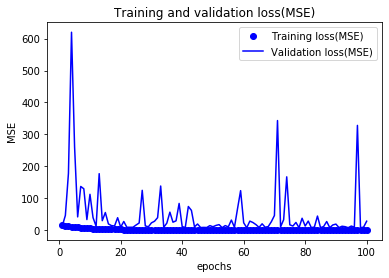

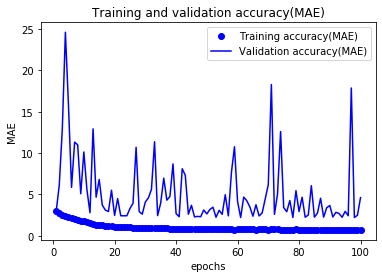

124/124 [==============================] - 2s 13ms/step - loss: 31.1750 - mean_absolute_error: 4.6709
Test MAE: 4.671
(3942, 1)
(3942,)
AxesSubplot(0.125,0.125;0.775x0.755)


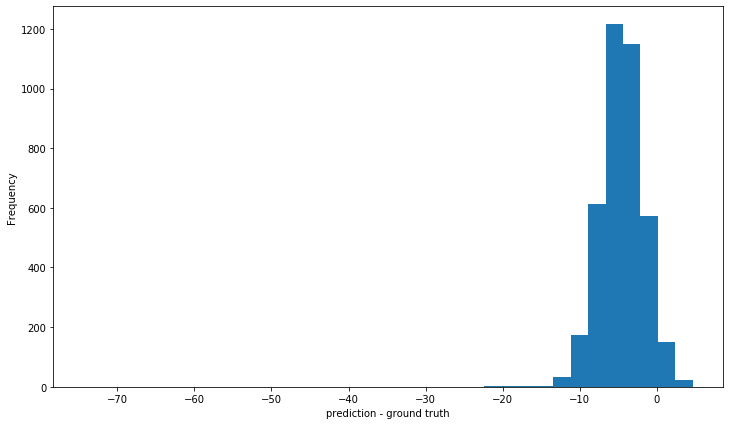

[[1.        0.4289302]
 [0.4289302 1.       ]]


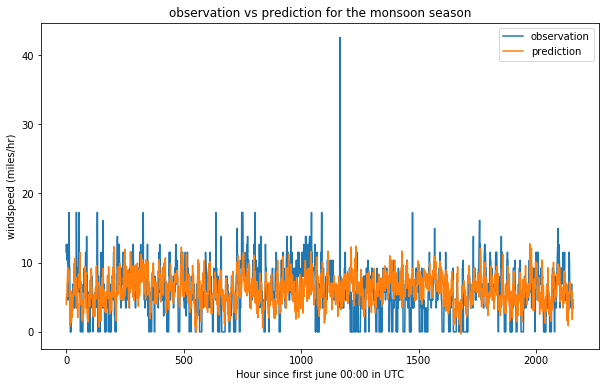

(8736, 1)
(8736,)
AxesSubplot(0.125,0.125;0.775x0.755)


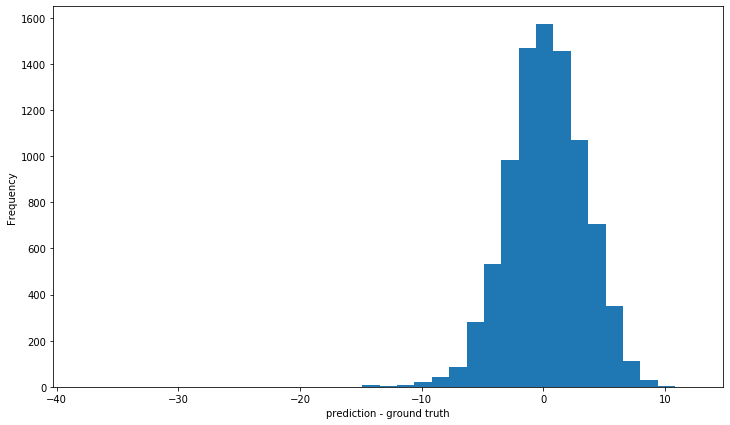

(6592,)
AxesSubplot(0.125,0.125;0.775x0.755)


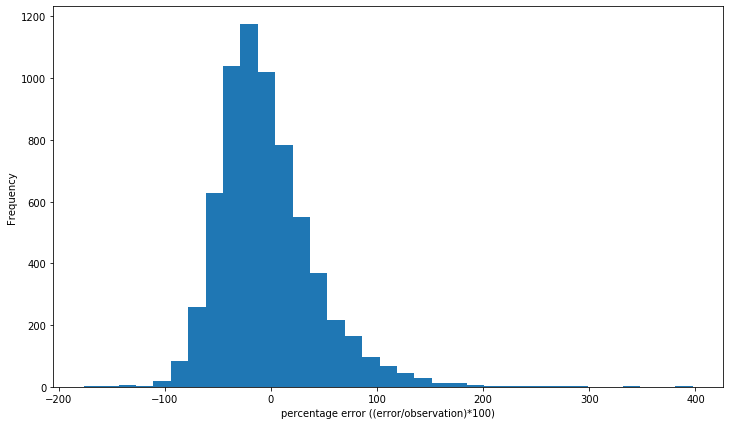

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


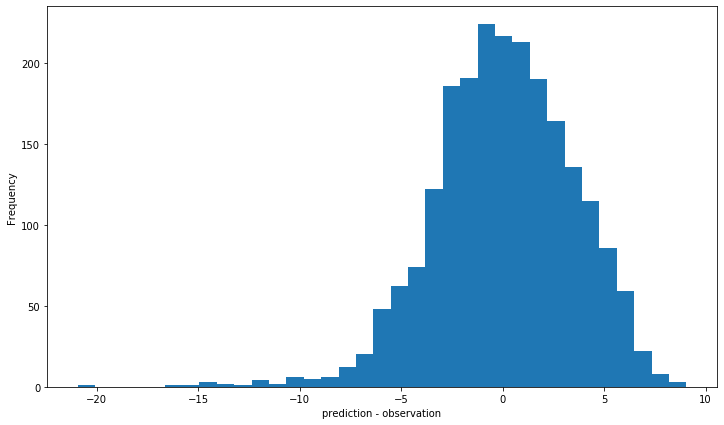

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


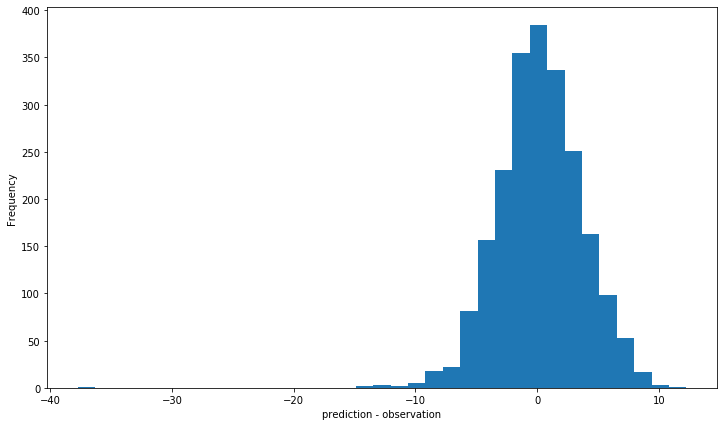

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


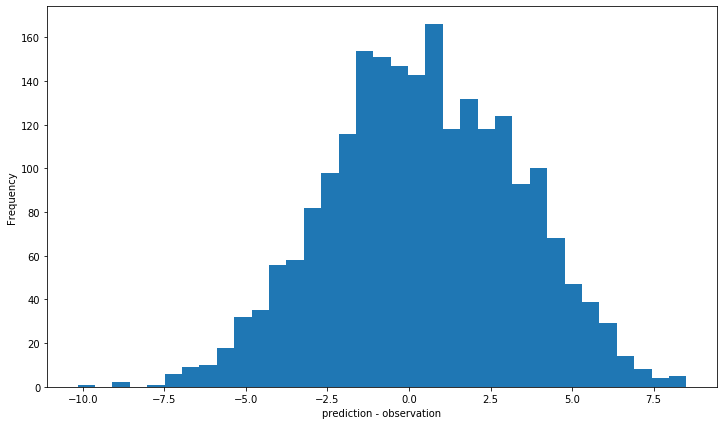

(2184,)
AxesSubplot(0.125,0.125;0.775x0.755)


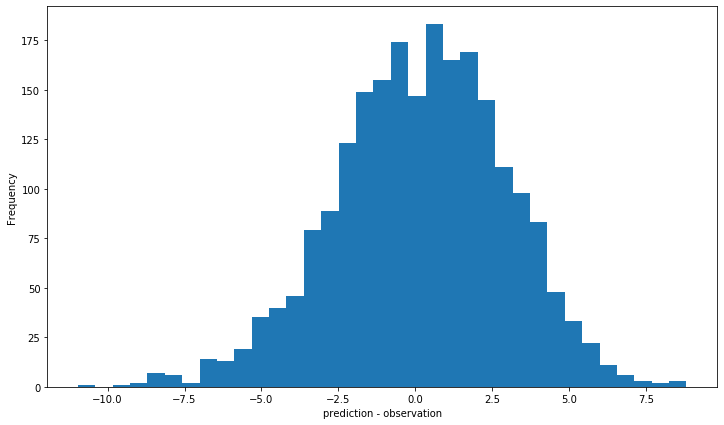

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_windspeed(code):
    arr = np.load("WindSpeed_ArrayFinal.npy")
    idx = airports.index(code)
    return arr[:, idx].astype(np.float32)

def get_era_full(param, level):
    arr = np.load("18To20{}{}_uint8.npy".format(param, level))
    return arr/256

# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

# data for a given airport
X = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
Y = get_windspeed('VIDP').reshape(-1, 1)

import sklearn
from sklearn.model_selection import train_test_split

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, Y_train, Y_rem = train_test_split(X,Y, train_size=0.7)

# Now since we want the valid and test size to be equal. 
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem,Y_rem, test_size=0.5)

train_features = X_train
train_labels = Y_train
val_features = X_valid
val_labels = Y_valid
test_features = X_test
test_labels = Y_test

#to clear space for gpu, if occupied by any process
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

# model

initializer = tf.keras.initializers.HeUniform()
inputs = keras.Input(shape=(157, 157, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_initializer = initializer)(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu", kernel_initializer = initializer)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
top_dropout_rate = 0.4
x = layers.Dropout(top_dropout_rate)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs, name="Basic2dCNN")

# compiling the model
opt =tf.keras.optimizers.RMSprop(learning_rate=0.002)
model.compile(loss = 'mse', optimizer = opt, metrics = [tf.keras.losses.MeanAbsoluteError()])
callbacks = [keras.callbacks.ModelCheckpoint(filepath = f"wVIDP_2D.keras",
                                            save_best_only = True, monitor = "val_loss")]

history = model.fit(train_features, train_labels, batch_size = 64, epochs = 100, validation_data = (val_features, val_labels), verbose = 0, callbacks = callbacks)

import matplotlib.pyplot as plt
%matplotlib inline
f1 = plt.figure();
mae = history.history["mean_absolute_error"]
loss = history.history["loss"]
val_mae = history.history["val_mean_absolute_error"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label = "Training loss(MSE)");
plt.plot(epochs, val_loss, "b", label = "Validation loss(MSE)");
plt.title("Training and validation loss(MSE)");
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend();

f2 = plt.figure();
plt.plot(epochs, mae, "bo", label = "Training accuracy(MAE)");
plt.plot(epochs, val_mae, "b", label = "Validation accuracy(MAE)");
plt.title("Training and validation accuracy(MAE)");
plt.legend();
plt.xlabel("epochs")
plt.ylabel("MAE")
plt.show();

test_loss, test_mae = model.evaluate(test_features, test_labels)
print(f"Test MAE: {test_mae:.3f}")
f1.savefig(f"wVIDP_2D.jpg", bbox_inches='tight', dpi=600);
f2.savefig(f"wVIDP_2D.jpg", bbox_inches='tight', dpi=600);

pred = model.predict(test_features)
error = pred - test_labels

import pandas as pd
print(error.shape)
error = np.reshape(error, (3942,))
print(error.shape)
x = pd.Series(error)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - ground truth")
plt.show();

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

airports = ['VABB', 'VOTV', 'VOBL', 'VECC', 'VIDP']

def get_windspeed(code):
    arr = np.load("windspeed21_22FINAL.npy")
    idx = airports.index(code)
    return arr[:, idx].astype(np.float32)

def get_era_full(param, level):
    arr = np.load("21To22{}{}_uint8final.npy".format(param, level))
    return arr/256

# Import data
params = ["z", "z", "z"]
levels = [500, 700, 1000]

in1_var = get_era_full(params[0], levels[0])
in2_var = get_era_full(params[1], levels[1])
in3_var = get_era_full(params[2], levels[2])

# data for a given airport
X = np.concatenate((np.expand_dims(in1_var, axis=3), np.expand_dims(in2_var, axis=3), np.expand_dims(in3_var, axis=3)), axis=3)
Y = get_windspeed('VIDP').reshape(-1, 1)

X_test = X
Y_test = Y

#to clear space for gpu, if occupied by any process
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

test_features = X_test
test_labels = Y_test

model = keras.models.load_model('wVIDP_2D.keras', compile = False)
pred = model.predict(test_features)
error = pred - test_labels

remove_idx = []
for i, j in enumerate(list(test_labels)):
    if j == 0.0:
        remove_idx.append(i)
        
test_labels2 = np.reshape(test_labels, (8736,))
pred2 = np.reshape(pred, (8736,))
test_labels2 = np.delete(test_labels2, remove_idx)
pred2 = np.delete(pred2, remove_idx)
error0 = pred2 - test_labels2
percent_error = (error0/test_labels2)*100

pearson_matrix = np.corrcoef(test_labels2, pred2)
print(pearson_matrix)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
#plt.plot(range(24*90), test_labels[:24*90], label = "observation")
#plt.plot(range(24*90), pred[:24*90], label = "prediction")
plt.plot(range(24*90), test_labels[24*90:24*2*90], label = "observation")
plt.plot(range(24*90), pred[24*90:24*2*90], label = "prediction")
#plt.plot(range(24*90), test_labels[24*2*90:24*3*90], label = "observation")
#plt.plot(range(24*90), pred[24*2*90:24*3*90], label = "prediction")
#plt.plot(range(24*90), test_labels[24*3*90:24*4*90], label = "observation")
#plt.plot(range(24*90), pred[24*3*90:24*4*90], label = "prediction")
plt.title("observation vs prediction for the monsoon season")
plt.legend()
plt.xlabel("Hour since first june 00:00 in UTC")
plt.ylabel("windspeed (miles/hr)")
plt.show();

import pandas as pd
print(error.shape)
error = np.reshape(error, (8736,))
print(error.shape)
x = pd.Series(error)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - ground truth")
plt.show();

import pandas as pd
print(percent_error.shape)
#error = np.reshape(percent_error, (8736-1205,))
#print(error.shape)
y = pd.Series(percent_error)
print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("percentage error ((error/observation)*100)")
plt.show();

#plot for summer
import pandas as pd
summer_err = error[:2184]
monsoon_err = error[2184:2*2184]
autumn_err = error[2*2184:3*2184]
winter_err = error[3*2184:]
error1 = np.reshape(summer_err, (2184,))
print(error1.shape)
x = pd.Series(error1)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for monsoon
error2 = np.reshape(monsoon_err, (2184,))
print(error2.shape)
x = pd.Series(error2)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for autumn
error3 = np.reshape(autumn_err, (2184,))
print(error3.shape)
x = pd.Series(error3)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();

#plot for winter
error4 = np.reshape(winter_err, (2184,))
print(error4.shape)
x = pd.Series(error4)
print(x.plot.hist(bins=35, figsize=[12, 7]))
#y = pd.Series(percent_error)
#print(y.plot.hist(bins=35, figsize=[12, 7]))
plt.xlabel("prediction - observation")
plt.show();